# Analysis-ready, cloud-optimized data: writing zarr directories

This tutorial will introduce analysis-ready, cloud-optimized (ARCO) data and describe one real-world example of restructuring some glaciological data and writing to an ARCO fromat, zarr. The data we will take a look at is from an ice-penetrating radar called the autonomous phase-sensitive radio-echo sounder (ApRES). 

A zarr store (or directory) is an ARCO data format that is ideally suited for storing high-dimensional, large volume data in the cloud. A key characteristic of zarr stores is that they are 'chunked', meaning that the data is broken up into smaller pieces. This allows for parallel access to the data, which is very useful when you are trying to access subsets of large datasets and/or process large volumes of data in parallel. 

Depending on the configuration of the ApRES radar, and the survey conducted, you can produce high-dimensional, very large volume datasets, making these data suitable for storage with zarrs. 

Before we get to the data we should make sure we understand what we mean by high-dimensional data and chunked data. 



## High-dimensional data: xarray
For our purposes, high-dimensional data is data that has more than 2 dimensions. For example, a typical satallite image is a two-dimensional dataset with two spatial dimensions, x and y (or latitude and longitude). If the satallite image has multiple bands it would be a three-dimensional dataset with two spatial dimensions and one band dimension, and if the satallite image has multiple time steps it would be a four-dimensional dataset with two spatial dimensions, one band dimension, and one time dimension. 

[Xarray](http://xarray.pydata.org/en/stable/) is a python package designed to allow you store and process high-dimensional data. It is built on top of [numpy](https://numpy.org/), which is deals with arrays of data. Xarray adds very useful features to numpy, including labelling of dimensions and broadcasting of operations across dimensions. Xarray also works very nicely with [dask](https://dask.org/), which is yet another python package, which allows you to 'chunk' your data and process it in parallel.

Before we get onto dask, let's take a look at xarray.

In [1]:
import xarray as xr

Let's load an example xarray dataset, supplied with the xarray package:

In [2]:
ds = xr.tutorial.load_dataset("air_temperature")
ds

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 241.2 242.5 243.5 ... 296.5 296.2 295.7
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

This provides a convenient way of viewing the structure of the data. We can see that there are three dimensions (`lat`, `lon` and `time`) and one variable (`air`). The variable `air` and the coorinates `lat`, `lon` and `time` are all stored as numpy arrays. You can access `air` and verify its type as follows:

In [3]:
ds.air.values[0:2, 0:2, 0:2]

array([[[241.2    , 242.5    ],
        [243.79999, 244.5    ]],

       [[242.09999, 242.7    ],
        [243.59999, 244.09999]]], dtype=float32)

In [4]:
print(f"The variable air has type {type(ds.air.values)}")

The variable air has type <class 'numpy.ndarray'>


A great thing about xarray is that it allows to very quickly take a look at, process and plot thees kind of data. For example, we can plot the mean of `air` over the `time` dimension as follows:

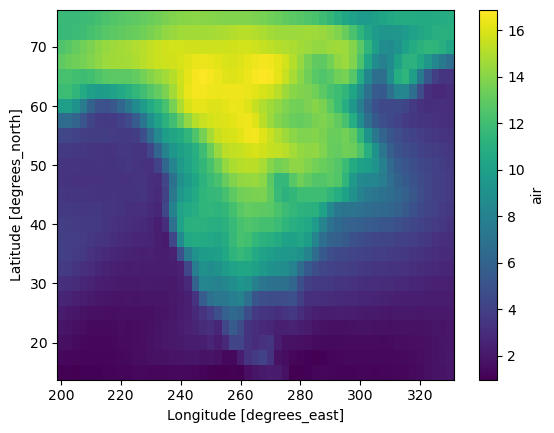

In [5]:
ds.air.std(dim="time").plot()


## Chunking: dask
The xarray abov (`ds`) contained 'ordinary' numpy arrays. To process or plot any part of a variable, we need to load all of it into memory. This is fine if the data are small; the dataset above was only

In [6]:
print(f"{ds.nbytes/1e6} MB")

15.499672 MB


but this would be an issue if a variable was, say, 100GB. This would be too large to fit into memory on most computers and would prevent you from processing or plotting the data. This is where chunking and dask come in. Dask provides a new data structure, called a dask array, which is exactly like a numpy array wexcept that it is split up into smaller pieces called chunks. Let's load an example dask array (straight from the dask [documentation](https://examples.dask.org/array.html#Create-Random-array)): 

In [7]:
import dask.array as da
x = da.random.random((1e6, 1e6), chunks=(5000, 5000))
x

dask.array<random_sample, shape=(1000000, 1000000), dtype=float64, chunksize=(5000, 5000), chunktype=numpy.ndarray>

This command createed a dask array containing random values between -0.5 and 0.5. Calling `x` displays a handy table containing information about this dask array. It's total size is 7TB! Clearly this is much too large to fit into memory. In fact, nothing has been loaded into memory except the structure of the dask array (i.e. the number and shape of the chunks) and the information needed to create it when we need it (i.e. the method `random`). 

The table also includes information on the chunks. There are 40,000 of them and each one is 190MB and 5000 by 5000 elements in size. Note that we chose this chunk size when we created the dask array. This is the key to dask arrays: we can choose the chunk size to suit our needs. Choosing the wrong chunk size can cause all sorts of issues, as we will see later in our real world example.

The great advantages of using dask array instead of an ordinary numpy array are 1) that we can view and plot a subset of the data without loading the whole thing into memory, and 2) we can process the data in parallel. Let's first load a subset of the data into memory and plot it:



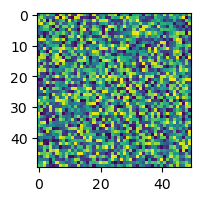

In [8]:
import matplotlib.pyplot as plt
x_sub = x[0:50, 0:50]
plt.figure(figsize=(2, 2))
plt.imshow(x_sub);

In [9]:
x_sub.nbytes/1e6

0.02

Next, let's start up a cluster and load and process a much larger subset of the data in parallel:

# ToDo when in cryocloud

## Xarray + dask
Xarray and dask work very nicely together. The we looked at above (`ds`) was made up of numpy arrays. We can instead tell xarray to load the data as odask arrays, therefore avoiding loading anything into memory until it iw needed. This is called lazily loading the data. We do this by defining the `chunks` argument when we load the data:

In [16]:
ds_dask = xr.tutorial.open_dataset('air_temperature',
                              chunks={'lat': 5, 'lon': 5, 'time': -1})
ds_dask

<xarray.Dataset>
Dimensions:  (lat: 25, time: 2920, lon: 53)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    air      (time, lat, lon) float32 dask.array<chunksize=(2920, 5, 5), meta=np.ndarray>
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

Now if we take a look at the variable `air` in `ds_dask` we can see that it is a dask array:

In [17]:
ds_dask.air

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
dask.array<open_dataset-air, shape=(2920, 25, 53), dtype=float32, chunksize=(2920, 5, 5), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         degK
    precision:     2
    GRIB_id:       11
    GRIB_name:     TMP
    var_desc:      Air temperature
    dataset:       NMC Reanalysis
    level_desc:    Surface
    statistic:     Individual Obs
    parent_stat:   Other
    actual_range:  [185.16 322.1 ]

## ApRES data --> xarray --> zarr --> dask 

In [22]:
import sys
xapres_directory = "/Users/jkingslake/Documents/science/ApRES/xapres_package/"
sys.path.append("/Users/jkingslake/Documents/science/ApRES/xapres_package/")
import xapres_package as xa

In [29]:
from_DAT_unattended = xa.load.generate_xarray(directory= xapres_directory +'data/sample/single_dat_file/')
from_DAT_unattended

<xarray.Dataset>
Dimensions:          (time: 1, chirp_time: 40001, chirp_num: 100,
                      attenuator_setting_pair: 1, profile_range: 11889)
Coordinates:
  * time             (time) datetime64[ns] 2023-01-05T03:16:15
  * chirp_time       (chirp_time) float64 0.0 2.5e-05 5e-05 ... 1.0 1.0 1.0
  * profile_range    (profile_range) float64 0.0 0.2103 ... 2.5e+03 2.5e+03
  * chirp_num        (chirp_num) int64 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
    filename         (time) <U108 '/Users/jkingslake/Documents/science/ApRES/...
    burst_number     (time) int64 0
    AFGain           (attenuator_setting_pair) int64 -4
    attenuator       (attenuator_setting_pair) float64 22.0
    orientation      (time) <U7 'unknown'
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 ...
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 ...
    latitude         (time) float64 0.0
    longitude        (time) float64 0.0
    battery_voltage  (time) float64 0.0
    temperature_1    (time) float64 2.891
    temperature_2    (time) float64 511.8